Digits dataset clustering using DBSCAN

In [1]:
import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import fetch_openml
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score

import umap
import umap.plot as uplot

import hdbscan
import hdbscan.validity

from kneed import KneeLocator

from sklearn.decomposition import PCA

random.seed(2)
sns.set_theme()

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, e

In [2]:
#Data Loading 

In [3]:
# Load digits data
mnist = fetch_openml('mnist_784', parser='auto')

# Normalize digits data
digits_data = mnist.data/255
digit_labels = mnist.target

# Subset the dataset
digit_labels_df = pd.DataFrame(digit_labels)

label_subset_df = digit_labels_df.groupby('class').head(2000)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

/var/folders/h2/hlt0n3hj3jx4phv5m7ncq2180000gn/T/ipykernel_4691/116597743.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_subset_df = digit_labels_df.groupby('class').head(2000)


In [4]:
digits_data.shape

(20000, 784)

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

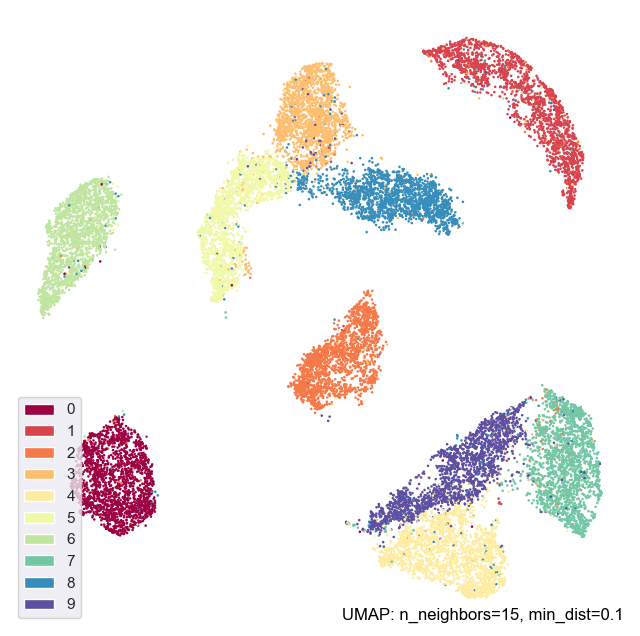

In [5]:
# Default values
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(digits_data)

uplot.points(umap_obj, labels=digit_labels)

## Methods for choosing default parameters for DBSCAN

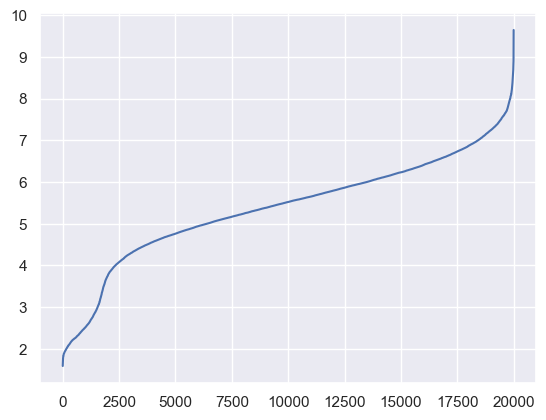

In [6]:
# Identify MinPts
min_pts = int(np.log(digits_data.shape[0]))

# Find distances to min_pts'th neighbor
knn = NearestNeighbors()
knn.fit(digits_data)
distances, _ = knn.kneighbors(digits_data, n_neighbors=min_pts)


# Sort the dsitances to min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

# Plot and search for the knee
plt.plot(range(sort_dist.shape[0]), sort_dist)

In [8]:
# Cluster again
dbscan_tun = DBSCAN(eps=7, min_samples=min_pts)
_ = dbscan_tun.fit(digits_data)

np.unique(dbscan_tun.labels_)

array([-1,  0])

In [ ]:
#Bad result

In [9]:
# Cluster again
dbscan_tun = DBSCAN(eps=6, min_samples=min_pts)
_ = dbscan_tun.fit(digits_data)

np.unique(dbscan_tun.labels_)

array([-1,  0,  1,  2,  3])

ARI : 0.011411391663305983


<Axes: >

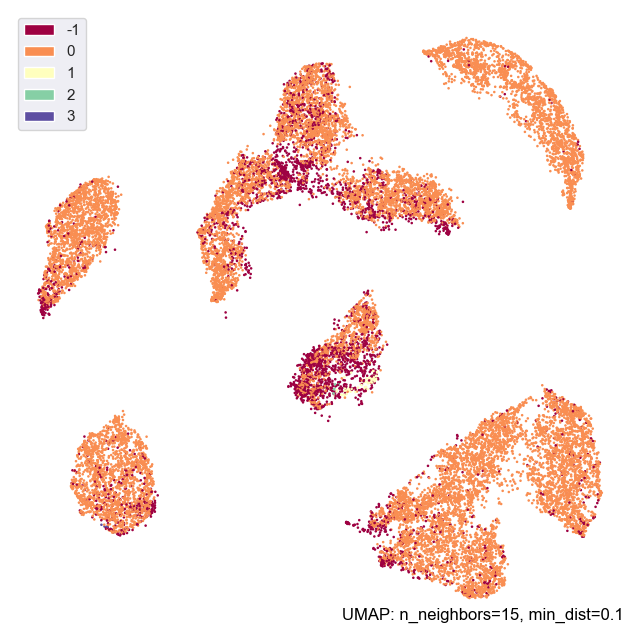

In [10]:
print('ARI : {}'.format(
    adjusted_rand_score(dbscan_tun.labels_, digit_labels)
    )
)

uplot.points(umap_obj, labels=dbscan_tun.labels_)

## DBSCAN With pca 

Number of PCA components 784


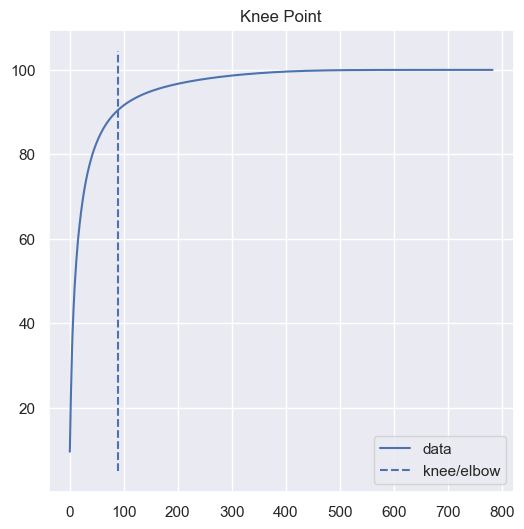

In [11]:
pca = PCA()
pca.fit(digits_data)
pca_transformed_data = pca.transform(digits_data)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)), 
    cumulative_explained_variance, 
    S=1.0, 
    curve="concave", 
    direction="increasing"
)
kneedle.plot_knee()

In [12]:
pca_transformed_data.shape

(20000, 784)

In [14]:
pca_reduced_data = pca_transformed_data[:, :100]

In [16]:
pca_reduced_data.shape

(20000, 100)

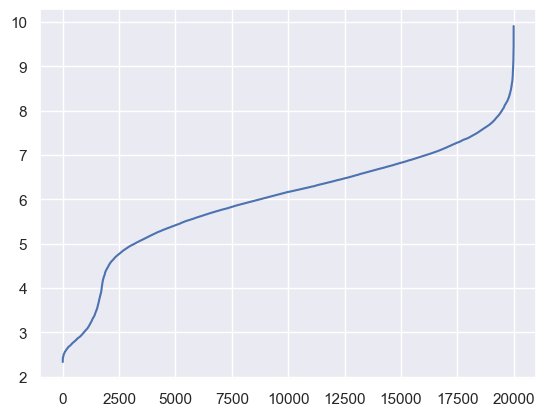

In [15]:
# Identify MinPts
min_pts =  pca_reduced_data.shape[1] + 1

# Find distances to min_pts'th neighbor
knn = NearestNeighbors(n_neighbors=min_pts+1)
knn.fit(pca_reduced_data)
distances, _ = knn.kneighbors(pca_reduced_data)


# Sort the distances to the min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

# Plot and search for a knee
plt.plot(range(sort_dist.shape[0]), sort_dist)

In [17]:
# Cluster again
dbscan_tun = DBSCAN(eps=2.5, min_samples=min_pts)
_ = dbscan_tun.fit(pca_reduced_data)

ARI : 0.005370671331482598


<Axes: >

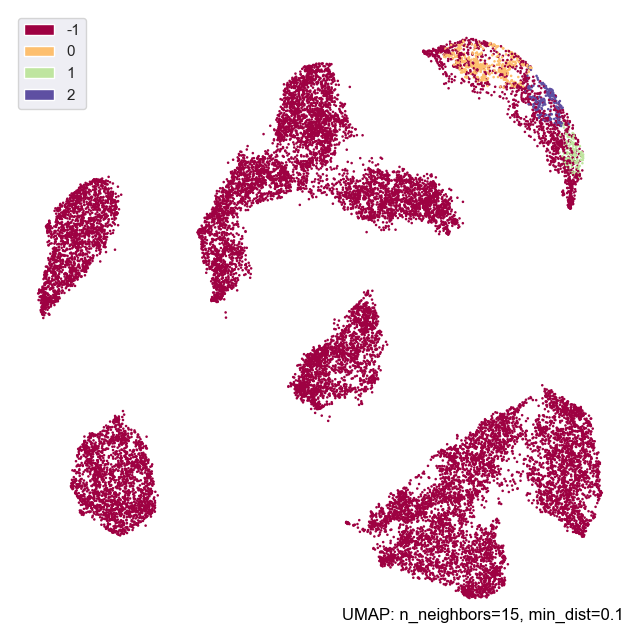

In [18]:
print('ARI : {}'.format(
    adjusted_rand_score(dbscan_tun.labels_, digit_labels)
    )
)

uplot.points(umap_obj, labels=dbscan_tun.labels_)

## Brute Force Search Implementation 

In [19]:
# Lists of candidate parameters
n_neighbor_list = [10, 20, 40, 80] + list(range(100, 600, 100))
eps_list = [1, 3, 6, 8, 10, 12]

# List to store results
result_list = []

print('Loop has started !')

# Iterate through the neighbors
for iter_i, n_neighbor in enumerate(n_neighbor_list):
    
    print('Done {}/{} for outter loop'.format(iter_i, len(n_neighbor_list)))
    
    # Take various eps thresholds and perform clustering
    for curr_eps in eps_list:
        
        curr_dbscan = DBSCAN(eps=curr_eps, min_samples=n_neighbor, n_jobs=-1)
        _ = curr_dbscan.fit(pca_reduced_data)
        
        # Get number of unique clusters by removing noise
        unique_clusters = [clust for clust in set(curr_dbscan.labels_) if clust != -1]
        
        # Create reduced version of the data
        np_labels = np.array(curr_dbscan.labels_)
        non_noise_idx = np.where(np_labels != -1)

        non_noise_labels = np_labels[non_noise_idx]
        digit_labels_sub = digit_labels[non_noise_idx]
        pca_data_sub = pca_reduced_data[non_noise_idx]
        noise_size = np_labels.shape[0] - non_noise_labels.shape[0]
        
        # If number of clusters is higher than 1, calculate and 
        # record the stats
        if len(unique_clusters) > 1:
            
            try:
                dbcv = hdbscan.validity.validity_index(pca_reduced_data, curr_dbscan.labels_, metric='euclidean')
            except:
                dbcv = -1
        
            result_list.append({
                'n_neigh': n_neighbor,
                'eps': curr_eps,
                'num_clust': len(set(curr_dbscan.labels_)),
                'silouethe': silhouette_score(pca_reduced_data, curr_dbscan.labels_, metric='euclidean'),
                'silouethe_sub': silhouette_score(pca_data_sub, non_noise_labels, metric='euclidean'),
                'dbcv': dbcv,
                'ari': adjusted_rand_score(digit_labels, curr_dbscan.labels_),
                'ari_sub': adjusted_rand_score(non_noise_labels, digit_labels_sub),
                'noise_size': noise_size
            })

# Obtain dataframe
result_df = pd.DataFrame.from_dict(result_list).round(3)

Loop has started !
Done 0/9 for outter loop
Done 1/9 for outter loop
Done 2/9 for outter loop
Done 3/9 for outter loop
Done 4/9 for outter loop
Done 5/9 for outter loop
Done 6/9 for outter loop
Done 7/9 for outter loop
Done 8/9 for outter loop


In [20]:
# Sort by dbcv
best_dbcv = result_df.sort_values(by='dbcv', ascending=False).head(10).reset_index(drop=True)
best_dbcv

,n_neigh,eps,num_clust,silouethe,silouethe_sub,dbcv,ari,ari_sub,noise_size
0,20,3,3,-0.055,0.299,0.049,0.042,1.000,18098
1,10,3,9,-0.114,0.177,0.025,0.044,0.982,17786
2,10,6,3,0.073,0.118,-0.092,0.000,0.000,609
3,200,6,3,0.066,0.175,-0.306,0.061,0.025,6967


<Axes: >

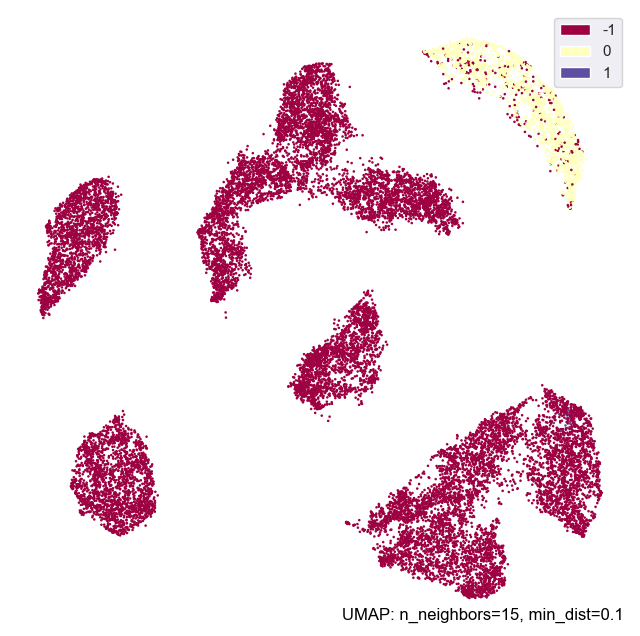

In [21]:
dbscan_tun = DBSCAN(
    eps=best_dbcv.loc[0,'eps'], 
    min_samples=best_dbcv.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)

In [22]:
# Sort by silouethe score
best_silouethe = result_df.sort_values(by='silouethe', ascending=False).head(10).reset_index(drop=True)
best_silouethe

,n_neigh,eps,num_clust,silouethe,silouethe_sub,dbcv,ari,ari_sub,noise_size
0,10,6,3,0.073,0.118,-0.092,0.000,0.000,609
1,200,6,3,0.066,0.175,-0.306,0.061,0.025,6967
2,20,3,3,-0.055,0.299,0.049,0.042,1.000,18098
3,10,3,9,-0.114,0.177,0.025,0.044,0.982,17786


<Axes: >

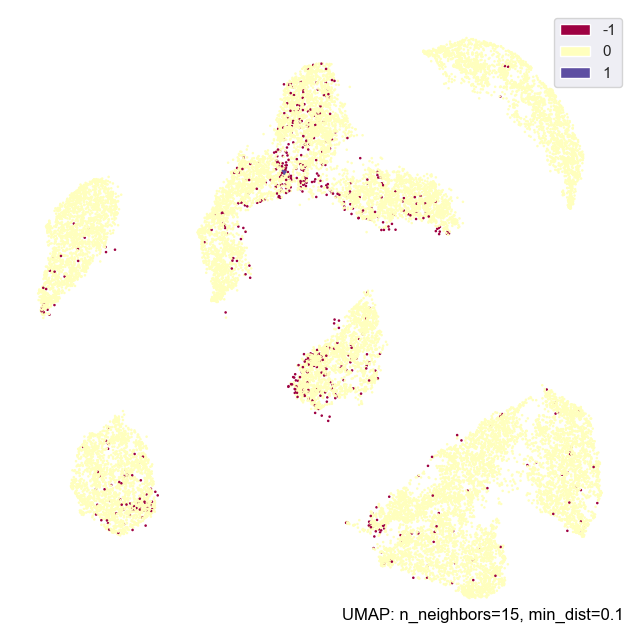

In [23]:
dbscan_tun = DBSCAN(
    eps=best_silouethe.loc[0,'eps'], 
    min_samples=best_silouethe.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)

In [24]:
# Sort by silouethe score for non-noise samples
best_silouethe_sub = result_df.sort_values(by='silouethe_sub', ascending=False).head(10).reset_index(drop=True)
best_silouethe_sub

,n_neigh,eps,num_clust,silouethe,silouethe_sub,dbcv,ari,ari_sub,noise_size
0,20,3,3,-0.055,0.299,0.049,0.042,1.000,18098
1,10,3,9,-0.114,0.177,0.025,0.044,0.982,17786
2,200,6,3,0.066,0.175,-0.306,0.061,0.025,6967
3,10,6,3,0.073,0.118,-0.092,0.000,0.000,609


<Axes: >

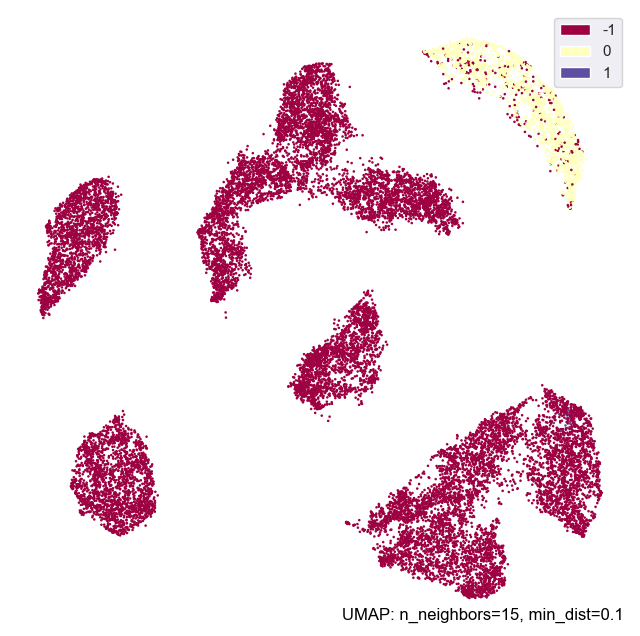

In [25]:
dbscan_tun = DBSCAN(
    eps=best_silouethe_sub.loc[0,'eps'], 
    min_samples=best_silouethe_sub.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)

In [26]:
# Sort by num_clust
high_clust_num = result_df.sort_values(by='num_clust', ascending=False).head(10).reset_index(drop=True)
high_clust_num

,n_neigh,eps,num_clust,silouethe,silouethe_sub,dbcv,ari,ari_sub,noise_size
0,10,3,9,-0.114,0.177,0.025,0.044,0.982,17786
1,10,6,3,0.073,0.118,-0.092,0.000,0.000,609
2,20,3,3,-0.055,0.299,0.049,0.042,1.000,18098
3,200,6,3,0.066,0.175,-0.306,0.061,0.025,6967


<Axes: >

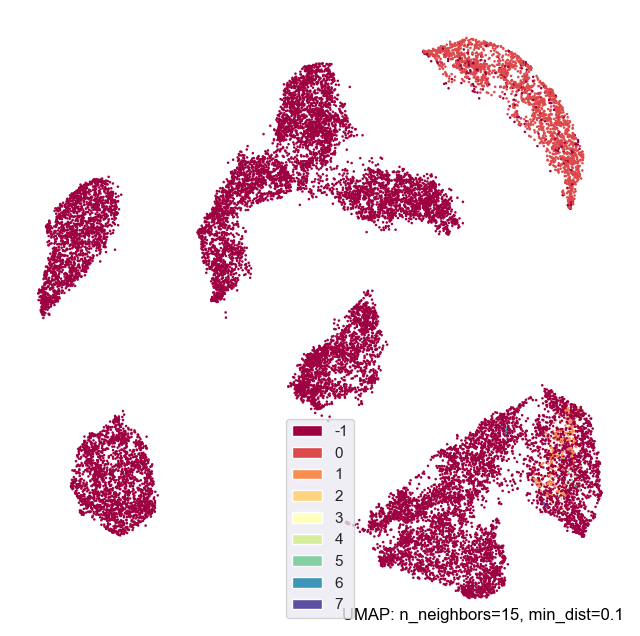

In [27]:
dbscan_tun = DBSCAN(
    eps=high_clust_num.loc[0,'eps'], 
    min_samples=high_clust_num.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)

In [28]:
# Sort by ari
best_ari = result_df.sort_values(by='ari', ascending=False).head(10).reset_index(drop=True)
best_ari

,n_neigh,eps,num_clust,silouethe,silouethe_sub,dbcv,ari,ari_sub,noise_size
0,200,6,3,0.066,0.175,-0.306,0.061,0.025,6967
1,10,3,9,-0.114,0.177,0.025,0.044,0.982,17786
2,20,3,3,-0.055,0.299,0.049,0.042,1.000,18098
3,10,6,3,0.073,0.118,-0.092,0.000,0.000,609


<Axes: >

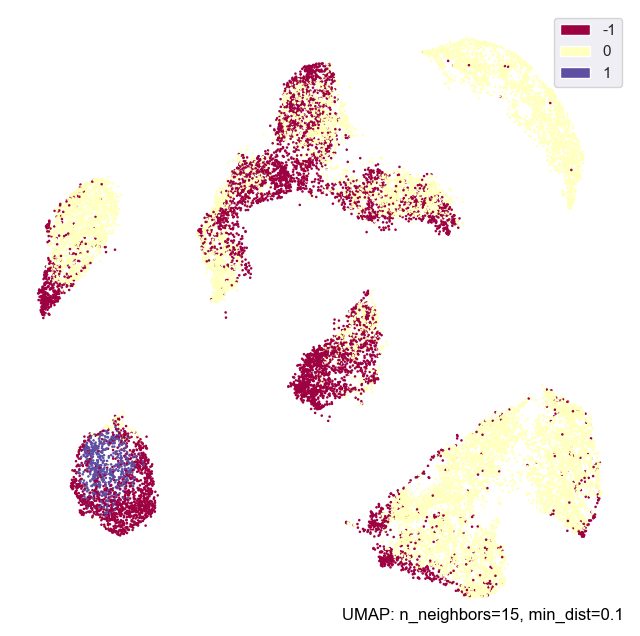

In [29]:
dbscan_tun = DBSCAN(
    eps=best_ari.loc[0,'eps'], 
    min_samples=best_ari.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)

In [30]:
# Sort by ari on non-noise samples
best_sub_ari = result_df.sort_values(by='ari_sub', ascending=False).head(10).reset_index(drop=True)
best_sub_ari

,n_neigh,eps,num_clust,silouethe,silouethe_sub,dbcv,ari,ari_sub,noise_size
0,20,3,3,-0.055,0.299,0.049,0.042,1.000,18098
1,10,3,9,-0.114,0.177,0.025,0.044,0.982,17786
2,200,6,3,0.066,0.175,-0.306,0.061,0.025,6967
3,10,6,3,0.073,0.118,-0.092,0.000,0.000,609


<Axes: >

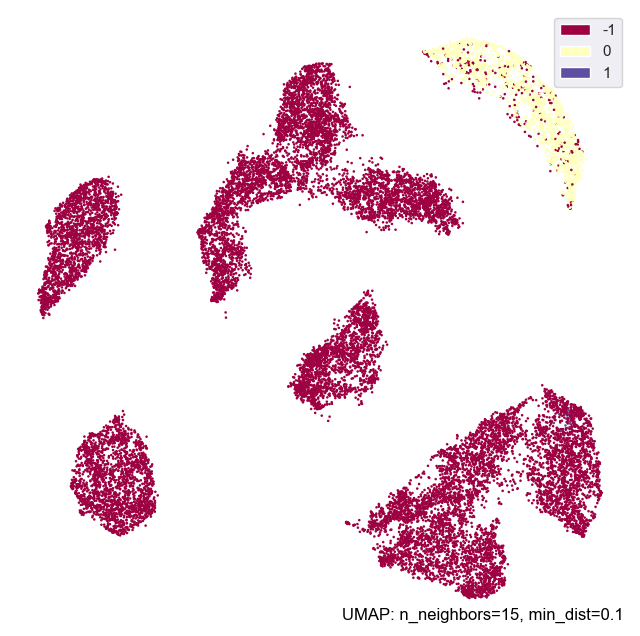

In [31]:
dbscan_tun = DBSCAN(
    eps=best_sub_ari.loc[0,'eps'], 
    min_samples=best_sub_ari.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)